### Transform CESM-LE data to fit Observational Data

#### Steps

1. Load DJF annual datasets
    * observational data (obs)
    * cesm-le data (sim)
2. Assign and calculate all parts for affine transformation equation
    * visually inspect data as you go
3. Compute transformation
4. Visualize the comparrison
5. Re-compute KGP based on transformed environmental data


In [1]:
#for pop_tools to work, use krill kernel

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


### Step 1: pull in annual DJF datasets
#### a) observational dataset (obs)

In [2]:
# Load Observational Datasets:
obs_temp = xr.open_zarr(f'{util.project_tmpdir}/oisst-avhrr-v02r01.1990-2019_DJF.POP_gx1v6.zarr')
#obs_temp

#### Clip it to Southern Ocean

In [3]:
#load grid and set latitude slice for Southern Ocean
grid = pop_tools.get_grid('POP_gx1v6')
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
grid = grid.isel(nlat=lat_slice)

In [4]:
#rename to match simulation convention
obs_temp['SST'] = obs_temp['sst']

#select specific variables to include in sliced dataset
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'time']
data_vars = ['anom', 'err','ice','SST']

#slice dataset to the southern ocean
ds_obs_sst = obs_temp[data_vars+grid_vars].isel(nlat=lat_slice)
ds_obs_sst

,Array,Chunk
Bytes,6.90 MB,238.08 kB
Shape,"(29, 93, 320)","(1, 93, 320)"
Count,59 Tasks,29 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.90 MB,238.08 kB
Shape,"(29, 93, 320)","(1, 93, 320)"
Count,59 Tasks,29 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [5]:
obs_chl = xr.open_zarr(f'{util.project_tmpdir}/seawifs_mapped_monthly_chl_gsm_DJF.POP_gx1v6.zarr')
obs_chl

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 12)
Coordinates:
    TLAT     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLONG    (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
  * time     (time) int64 1998 1999 2000 2001 2002 ... 2005 2006 2007 2009 2010
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA    (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    chl_gsm  (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

In [6]:
#rename to match simulation convention
obs_chl['Chl_surf'] = obs_chl['chl_gsm']

#select specific variables to include in sliced dataset
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'time']
data_vars = ['Chl_surf']

#slice dataset to the southern ocean
ds_obs_chl = obs_chl[data_vars+grid_vars].isel(nlat=lat_slice)
ds_obs_chl

<xarray.Dataset>
Dimensions:   (nlat: 93, nlon: 320, time: 12)
Coordinates:
    TLAT      (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
    TLONG     (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
  * time      (time) int64 1998 1999 2000 2001 2002 ... 2005 2006 2007 2009 2010
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf  (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
    KMT       (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
    TAREA     (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>

#### 1b) cesm-le dataset (sim)

In [7]:
# Load Simulated Dataset:
ds_sim = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_sim

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    IFRAC          (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP            (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    NPP            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

AttributeError: 'Rectangle' object has no property 'levels'

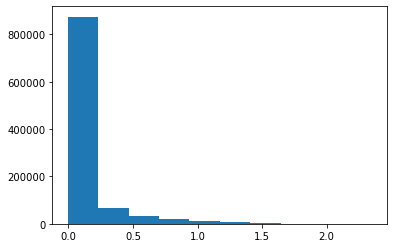

In [28]:
#preview data
levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]
ds_sim.Chl_surf.sel(time=2000, ).plot(levels = levels);

### Step 2. calculate all the bits for the transformation
\begin{equation*}
S_{trans} = \frac{\sigma_{obs}}{\sigma_{sim}}(S_{sim} - \mu_{sim})+\mu_{obs}
\end{equation*}

* std of observed data ($\sigma_{obs}$)
* std of model ($\sigma_{sim}$)
* state variable, either temperature of chl ($S_{sim}$)
* mean of simulation ($\mu_{sim}$)
* observational mean of sst ($\mu_{obs}$)
* log transformed chl: 
    example: mod_log_trans = np.log10(dsmod.Chl_surf.where(dsmod.Chl_surf>0))
    obs_log_trans = np.log10(dsobs.chl_gsm.where(dsobs.chl_gsm>0))

In [8]:
#observational dataset
S_obs_sst = ds_obs_sst['SST']
S_obs_chl = ds_obs_chl['Chl_surf']

#std of observed data
sigma_obs_sst = ds_obs_sst['SST'].std() 
sigma_obs_chl = ds_obs_chl['Chl_surf'].std() 

#std of model data 
sigma_sim_sst = ds_sim['SST'].std()
sigma_sim_chl = ds_sim['Chl_surf'].std()

#state variable
S_sim_sst = ds_sim['SST']
S_sim_chl = ds_sim['Chl_surf']

#mean of simulation
mu_sim_sst = ds_sim['SST'].mean()
mu_sim_chl = ds_sim['Chl_surf'].mean()

#observational mean of sst
mu_obs_sst = ds_obs_sst['SST'].mean()
mu_obs_chl = ds_obs_chl['Chl_surf'].mean()


### check out the data:

In [9]:
#Make things into vectors for PDFs
S_obs_sst_v = S_obs_sst.values.ravel()
S_obs_chl_v = S_obs_chl.values.ravel()

S_sim_sst_v = S_sim_sst.values.ravel()
S_sim_chl_v = S_sim_chl.values.ravel()

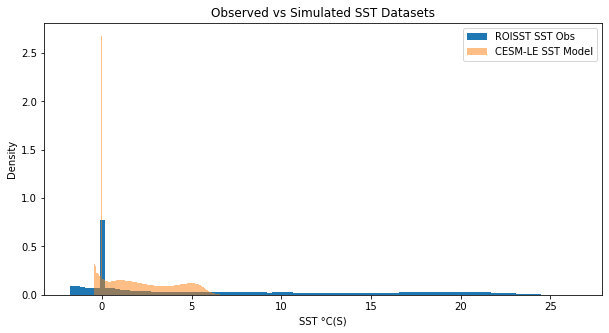

In [10]:
#Plot Observational and Model Data - SST
plt.figure(figsize=(10, 5))
plt.hist(S_obs_sst_v, 100, density=True, label = 'ROISST SST Obs' )
plt.hist(S_sim_sst_v, 100, density=True, alpha=0.5, label='CESM-LE SST Model')
plt.xlabel('SST °C(S)')
plt.ylabel('Density')
plt.legend()
plt.title('Observed vs Simulated SST Datasets')
plt.show();

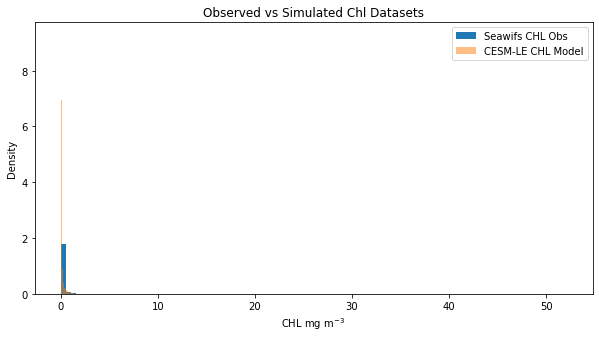

In [11]:
#Plot Observational and Model Data - CHL
plt.figure(figsize=(10, 5))
plt.hist(S_obs_chl_v, 100, density=True, label = 'Seawifs CHL Obs' )
plt.hist(S_sim_chl_v, 100, density=True, alpha=0.5, label='CESM-LE CHL Model')
plt.xlabel('CHL mg m$^{-3}$')
plt.ylabel('Density')
plt.legend()
plt.title('Observed vs Simulated Chl Datasets')
plt.show();

## 3. Transform the simulated data to match the std and mean of the observed data:
* subtract the mean of simulation from s_sim
* multiply by 3 scales the anomolies bu the ratios of the standard deviations
* then add back the observational mean (if it's chl be sure to log transform it first)


In [10]:
# for SST:
S_transformed_sst = np.exp(sigma_obs_sst * (S_sim_sst - mu_sim_sst) / sigma_sim_sst + mu_obs_sst)
S_transformed_sst

<xarray.DataArray 'SST' (time: 180, member_id: 34, nlat: 93, nlon: 320)>
dask.array<exp, shape=(180, 34, 93, 320), dtype=float64, chunksize=(180, 1, 93, 320), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon

In [11]:
# for Chl:
S_transformed_chl = np.exp(sigma_obs_chl * (np.log(S_sim_chl) - mu_sim_chl) / sigma_sim_chl + mu_obs_chl)
S_transformed_chl

<xarray.DataArray 'Chl_surf' (time: 180, member_id: 34, nlat: 93, nlon: 320)>
dask.array<exp, shape=(180, 34, 93, 320), dtype=float64, chunksize=(180, 1, 93, 320), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon

### 4. Visualize the Transformed Data

In [12]:
#Make things into vectors for PDFs
S_trans_sst_v = S_transformed_sst.values.ravel()
S_trans_chl_v = S_transformed_chl.values.ravel()

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


In [32]:
plt.close()

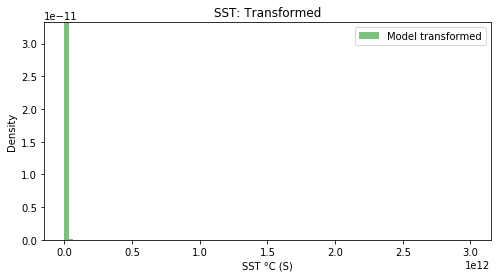

In [16]:
plt.figure(figsize=(8, 4))
#plt.hist(S_obs_sst_v, 100, density=True, color = 'blue', label='Observed')
plt.hist(S_trans_sst_v, 100, density=True, alpha=0.5, color = 'green', label='Model transformed')
plt.title('SST: Transformed')#Observation vs Transformed Simulation')
plt.xlabel('SST °C (S)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [14]:
plt.close()

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


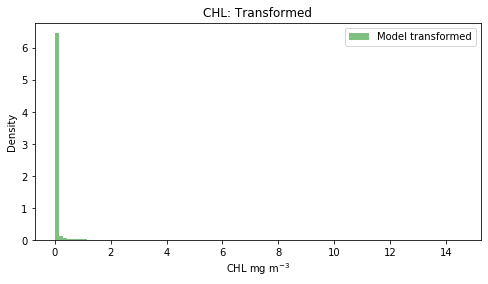

In [15]:
plt.figure(figsize=(8, 4))
#plt.hist(S_obs_chl_v, 100, density=True, color = 'blue' label='Observed')
plt.hist(S_trans_chl_v, 100, density=True, alpha=0.5, color = 'green', label='Model transformed')
plt.title('CHL: Transformed')#Observation v Transformed Simulation')
plt.xlabel('CHL mg m$^{-3}$')
plt.ylabel('Density')
plt.legend()
plt.show()

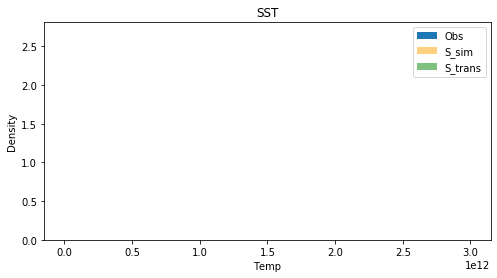

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(S_obs_sst_v, 100, density=True, label='Obs');
plt.hist(S_sim_sst_v,  100, density=True, alpha=0.5,color = 'orange', label='S_sim');
plt.hist(S_trans_sst_v, 100, density=True, alpha=0.5, color = 'green', label='S_trans');
plt.xlabel('Temp')
plt.ylabel('Density')
plt.title('SST')
plt.legend();

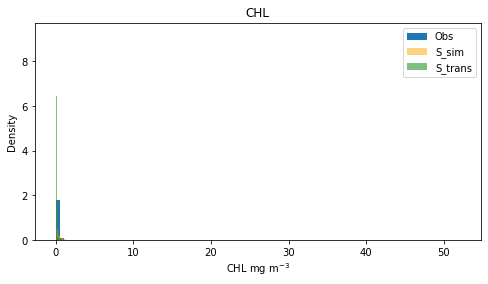

In [20]:
plt.figure(figsize=(8, 4))
plt.hist(S_obs_chl_v, 100, density=True, label='Obs');
plt.hist(S_sim_chl_v,  100, density=True, alpha=0.5, color = 'orange', label='S_sim');
plt.hist(S_trans_chl_v, 100, density=True, alpha=0.5, color = 'green', label='S_trans')
plt.title('CHL')
plt.xlabel('CHL mg m$^{-3}$')
plt.ylabel('Density')
plt.legend();

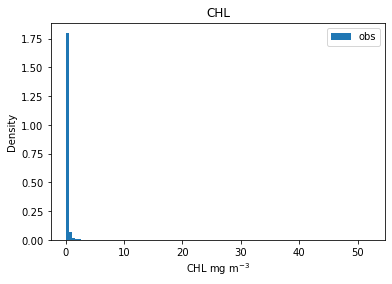

In [29]:
plt.figure()
plt.hist(S_obs_chl_v, 100, density=True, label='obs');
#plt.hist(S_trans_chl_v, 100, density=True, alpha=0.5, color = 'green', label='S_trans');
#plt.hist(S_sim_chl_v,  50, density=True, alpha=0.5,color = 'orange', label='S_sim');
plt.title('CHL')
plt.xlabel('CHL mg m$^{-3}$')
plt.ylabel('Density')
plt.legend();

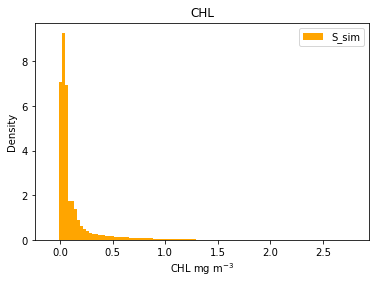

In [23]:
plt.figure()
#plt.hist(S_obs_chl_v, 50, density=True, label='obs');
#plt.hist(S_trans_chl_v, 100, density=True, alpha=0.5, color = 'green', label='S_trans');
plt.hist(S_sim_chl_v,  100, density=True, color = 'orange', label='S_sim');
plt.title('CHL')
plt.xlabel('CHL mg m$^{-3}$')
plt.ylabel('Density')
plt.legend()
plt.show();